In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import gc
from torch.utils.data import DataLoader
from discriminator_utils import COCO2017
import torchvision.utils
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# get training data
dataset = COCO2017('./train_annotations.json', r'C:\Users\danie\Documents\Data\COMP652\FinalProject\train2017', 76800)
data_loader = DataLoader(dataset, batch_size=64)
# get validation data
val_dataset = COCO2017('./val_annotations.json', r'C:\Users\danie\Documents\Data\COMP652\FinalProject\train2017', 6400)
val_data_loader = DataLoader(val_dataset, batch_size=64)

In [4]:
class CGenerator(nn.Module):
    # define constructor for the generator
    def __init__(self, noise_in_dimension, noise_out_dimension, vocab_size, embedding_length=128):
        # inherit nn.Module class methods
        super().__init__()
        # set class attributes:
        # model branch at start of model structure for noise (image)
        self.initial_noise_processing = nn.Sequential(nn.Linear(in_features=noise_in_dimension, out_features=4*4*noise_out_dimension, bias=True), nn.CELU(alpha=1, inplace=True))
        # moddel branch at start of model structure (parallel to noise branch) for condition (text)
        self.initial_condition_processing = nn.Sequential(nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_length, padding_idx=1), nn.Linear(in_features=embedding_length, out_features=16), nn.LeakyReLU(negative_slope=0.1, inplace=True))
        self.generator_model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=59+noise_out_dimension, out_channels=64*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64*8), # momentum parameter
            nn.ReLU(inplace=True), # 64x512x8x8
            nn.ConvTranspose2d(in_channels=64*8, out_channels=64*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64*4),
            nn.ReLU(inplace=True), # 64x256x16x16
            nn.ConvTranspose2d(in_channels=64*4, out_channels=64*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64*2),
            nn.ReLU(inplace=True), # 64x128x32x32
            # nn.ConvTranspose2d(in_channels=64*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(num_features=64),
            # nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh() #64x3x64x64
            )
        
    def forward(self, noise, text, batch_size=64):
        preconcat_noise = self.initial_noise_processing(noise)
        # reshape noise data
        preconcat_noise = torch.reshape(preconcat_noise, (-1, 512, 4, 4))
        preconcat_text = self.initial_condition_processing(text)
        # reshape text data
        preconcat_text = torch.reshape(preconcat_text, (batch_size, 944))
        preconcat_text = torch.reshape(preconcat_text, (-1, 59, 4, 4))
        # concatenate the image data and text data
        image_and_text = torch.concat((preconcat_noise, preconcat_text), dim=1)
        generative_result = self.generator_model(image_and_text)
        return generative_result
    




class Discriminator(nn.Module):
    def __init__(self, nc, ndf, opt):
        super(Discriminator, self).__init__()
        self.opt = opt
        self.nc = nc
        self.ndf = ndf
        self.convD = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.fcD = nn.Sequential(
            nn.Linear(opt['txtSize'], opt['nt']),
            nn.BatchNorm1d(opt['nt']),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.netD = nn.Sequential(
            nn.Conv2d(ndf * 8 + opt['nt'], ndf * 8, kernel_size=1),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, kernel_size=4),
            nn.Sigmoid()
        )

    def forward(self, img, txt):
        conv_output = self.convD(img)
        replicated_txt = self.fcD(txt.float())
        concatenated_input = torch.cat((conv_output, replicated_txt.unsqueeze(2).unsqueeze(3).repeat(1, 1, conv_output.size(2), conv_output.size(3))), dim=1)
        output = self.netD(concatenated_input)
        return output.view(-1, 1).squeeze(1)
    




text_tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-small')

def visualization_helper(data):
    print(plt.imshow(np.transpose(data)))

# dictionary for discriminator model parameters
opt = {
    'txtSize': 59, # Determined by max_length in tokenizing
    'nt': 128,
    'ndf': 64,
    'nc': 3, # number of input channels, for RGB images in COCO is 3x64x64
}

In [16]:
# assign an instance of the Discriminator Class to a variable
discriminator = Discriminator(opt['nc'], opt['ndf'], opt).to('cuda')
print(discriminator)
# assign an instance of the CGenerator Class to a variable
generator = CGenerator(noise_in_dimension=100, noise_out_dimension=512, vocab_size=text_tokenizer.vocab_size).to('cuda') #24784
print(generator)
# define the loss function
loss = nn.BCELoss()
# define optimizers with learning rate and momentum (Beta1) defined in research paper for the generator
discriminator_optimizer = optim.Adam(params=discriminator.parameters(), lr=0.005, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(params=generator.parameters(), lr=0.001, betas=(0.8, 0.999))
# define learning rate schedulers for generator and discriminator
# generator_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=generator_optimizer, factor=0.1, patience=10)
# discriminator_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=discriminator_optimizer, factor=0.1, patience=10)

Discriminator(
  (convD): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fcD): Sequential(
    (0): Linear(in_features=59, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [17]:
epoch_count = 135
batch_size = 64
discriminator_epoch_loss_list = []
generator_epoch_loss_list = []

discriminator_val_loss_list = []
generator_val_loss_list = []

no_improvement_count = 0
best_loss = np.inf

# test_data_loader = DataLoader(val_dataset, batch_size=1)
# test_text = [torch.tensor(next(iter(test_data_loader))[1]).to('cuda') for i in range(2)]
# get noise from normal distribution to be used for test images
# test_noise = torch.randn(1, 100, device='cuda')
# test_image_results = []


for epoch in range(epoch_count): # train GAN epoch_count number of times
    discriminator_batch_loss_list = []
    generator_batch_loss_list = []
    epoch_start = time.time()
    for idx, (image, text) in enumerate(data_loader, 0): # iterate through the training data loader (get batched data)
        # batch_start = time.time()
        text = text_tokenizer(text, max_length=59, padding='max_length', truncation=True).input_ids
        text = torch.as_tensor(text)
        image = image.to('cuda')
        text = text.to('cuda')
        # text_4g = torch.unsqueeze(text, 1).long()
        if idx % 2 == 0:
            # set gradient for all discriminator parametrs to None
            discriminator.zero_grad()
            # get discriminator predictions
            predictions_real = discriminator(image, text)
            # vector of ones
            labels_real = torch.ones(predictions_real.size(0)).to('cuda')
            # get discriminator loss on real images
            d_batch_loss_real = loss(predictions_real, labels_real)
            # backwards propogation for discriminator (these gardients will be accumulated with the gradients from the synthetic image results)
            d_batch_loss_real.backward()
            # get noise from normal distribution for this batch round
            noise = torch.randn(batch_size, 100, device='cuda')
            # generate synthetic images
            synthetic = generator(noise, text)
            # get discriminator predictions on synthetic images
            predictions_synthetic = discriminator(synthetic.detach(), text)
            # vector of zeros
            labels_synthetic = torch.zeros(predictions_synthetic.size(0)).to('cuda')
            # get discriminator loss on synthetic images
            d_batch_loss_synthetic = loss(predictions_synthetic, labels_synthetic)
            # backwards propogation for discriminator (these gardients are accumulated with the gradients from the real image results)
            d_batch_loss_synthetic.backward()
            # update discriminator
            discriminator_optimizer.step()
        else:
            # get discriminator predictions
            predictions_real = discriminator(image, text)
            # vector of ones
            labels_real = torch.ones(predictions_real.size(0)).to('cuda')
            # get discriminator loss on real images
            d_batch_loss_real = loss(predictions_real, labels_real)
            # get noise from normal distribution for this batch round
            noise = torch.randn(batch_size, 100, device='cuda')
            # generate synthetic images
            synthetic = generator(noise, text)
            # get discriminator predictions on synthetic images
            predictions_synthetic = discriminator(synthetic.detach(), text)
            # vector of zeros
            labels_synthetic = torch.zeros(predictions_synthetic.size(0)).to('cuda')
            # get discriminator loss on synthetic images
            d_batch_loss_synthetic = loss(predictions_synthetic, labels_synthetic)
        # set gradient for all generator parametrs to None
        generator.zero_grad(set_to_none=True)
        # get discriminator predictions on synthetic images
        predictions_synthetic_updated = discriminator(synthetic, text)
        # generator loss
        generator_batch_loss = loss(predictions_synthetic_updated, labels_real)
        # backwards propogation for generator
        generator_batch_loss.backward()
        # update generator
        generator_optimizer.step()

        # batch_end = time.time()
        # append discriminator batch loss
        discriminator_batch_loss_list.append(d_batch_loss_synthetic.item() + d_batch_loss_real.item()) 
        # append generator batch loss
        generator_batch_loss_list.append(generator_batch_loss.item())

        # print update every 300 batches
        # if idx % 300 == 0:
        #     print(f"Batch # {idx}==> Batch Loss (Discriminator): {discriminator_batch_loss_list[idx]}. Batch Loss (Generator): {generator_batch_loss}.") # Cumulative Average Batch Loss (Generator): {np.mean(generator_batch_loss_list)}
    epoch_end = time.time()
    print(f"Epoch {epoch}==> Duration (sec): {round((epoch_end - epoch_start),1)}. Average Training Batch Loss (Discriminator): {np.mean(discriminator_batch_loss_list)}. Average Training Batch Loss (Generator): {np.mean(generator_batch_loss_list)}.")
    generator_epoch_loss_list.append(np.mean(generator_batch_loss_list))
    discriminator_epoch_loss_list.append(np.mean(discriminator_batch_loss_list))
    
    discriminator_val_batch_loss_list = []
    generator_val_batch_loss_list = []

    with torch.no_grad():
        for idx, (image, text) in enumerate(val_data_loader, 0): # iterate through the training data loader (get batched data)
            # batch_start = time.time()
            text = text_tokenizer(text, max_length=59, padding='max_length', truncation=True).input_ids
            text = torch.as_tensor(text)
            val_image = image.to('cuda')
            val_text = text.to('cuda')
            # format text to be used as input to the generator
            # val_text_4g = torch.unsqueeze(val_text, 1).long()
            # get discriminator predictions
            val_predictions_real = discriminator(val_image, val_text)
            # vector of ones
            val_labels_real = torch.ones(val_predictions_real.size(0)).to('cuda')
            # get discriminator loss on real images
            val_d_batch_loss_real = loss(val_predictions_real, val_labels_real)
            # get noise from normal distribution for this batch round
            val_noise = torch.randn(batch_size, 100, device='cuda')
            # generate synthetic images
            val_synthetic = generator(val_noise, val_text)
            # get discriminator predictions on synthetic images
            val_predictions_synthetic = discriminator(val_synthetic.detach(), val_text)
            # vector of zeros
            val_labels_synthetic = torch.zeros(val_predictions_synthetic.size(0)).to('cuda')
            # get discriminator loss on synthetic images
            val_d_batch_loss_synthetic = loss(val_predictions_synthetic, val_labels_synthetic)
            # generator loss
            val_generator_batch_loss = loss(val_predictions_synthetic, val_labels_real)
            # batch_end = time.time()
            # append discriminator batch loss
            discriminator_val_batch_loss_list.append(val_d_batch_loss_synthetic.item() + val_d_batch_loss_real.item()) 
            # append generator batch loss
            generator_val_batch_loss_list.append(val_generator_batch_loss.item())
        # check (visualize) generator result every 5 epoch and lr status for generator and discriminator
        # if epoch % 5 == 0:
        #     test_synthetic = generator(test_noise, test_text[0], batch_size=1).detach().to('cpu')
        #     current_image_result = torchvision.utils.make_grid(tensor=test_synthetic, normalize=True)
        #     test_image_results.append(current_image_result)
        #     visualization_helper(current_image_result)
        #     plt.show()
    print(f"Average Validation Batch Loss (Discriminator): {np.mean(discriminator_val_batch_loss_list)}. Average Validation Batch Loss (Generator): {np.mean(generator_val_batch_loss_list)}.")
    generator_val_loss_list.append(np.mean(generator_val_batch_loss_list))
    discriminator_val_loss_list.append(np.mean(discriminator_val_batch_loss_list))

    # generator_lr_scheduler.step(generator_epoch_loss_list[epoch])
    # discriminator_lr_scheduler.step(discriminator_epoch_loss_list[epoch])
    # print(f"G LR Scheduler: {generator_lr_scheduler.get_last_lr()}")
    # print(f"D LR Scheduler: {discriminator_lr_scheduler.get_last_lr()} \n")
    

    # early stop condition. elected to ignore the first 3 epoch to let model "warm-up".
    if epoch >= 3:
        if generator_epoch_loss_list[epoch] < best_loss:
            no_improvement_count = 0
            best_loss = generator_val_loss_list[epoch]
        else:
            no_improvement_count+=0.5

        if no_improvement_count > 12:
            print("Early Stopping! Not Enough Generator Improvement!")
            break

Epoch 0==> Duration (sec): 16.5. Average Training Batch Loss (Discriminator): 1.041168237500389. Average Training Batch Loss (Generator): 4.455065036470381.
Average Validation Batch Loss (Discriminator): 0.30338482521940024. Average Validation Batch Loss (Generator): 2.0057734131813048.
Epoch 1==> Duration (sec): 16.1. Average Training Batch Loss (Discriminator): 0.9740968831022812. Average Training Batch Loss (Generator): 2.270195589835445.
Average Validation Batch Loss (Discriminator): 1.1368735802173615. Average Validation Batch Loss (Generator): 1.6377789640426637.
Epoch 2==> Duration (sec): 16.1. Average Training Batch Loss (Discriminator): 1.081526679226081. Average Training Batch Loss (Generator): 1.6455244641254345.
Average Validation Batch Loss (Discriminator): 1.0325599478185177. Average Validation Batch Loss (Generator): 0.9418060559034348.
Epoch 3==> Duration (sec): 16.2. Average Training Batch Loss (Discriminator): 1.104357961837474. Average Training Batch Loss (Generator)

In [18]:
torch.save(generator, r'C:\Users\danie\OneDrive\Documents\RiceUniversity\COMP 652\Text2Image_GAN\generator.pth')
torch.save(discriminator, r'C:\Users\danie\OneDrive\Documents\RiceUniversity\COMP 652\Text2Image_GAN\discriminator.pth')

Epoch 0==> Duration (sec): 13.7. Average Training Batch Loss (Discriminator): 1.4455545340752989. Average Training Batch Loss (Generator): 2.724792508034205.
AxesImage(size=(64, 64))


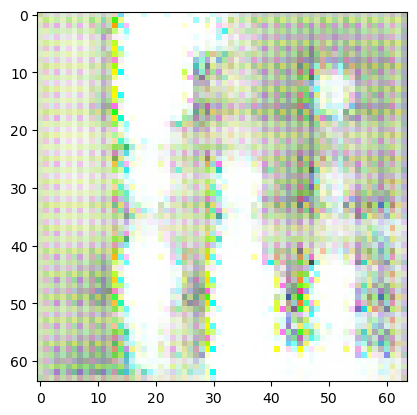

Average Validation Batch Loss (Discriminator): 2.0357228137552736. Average Validation Batch Loss (Generator): 2.841810493469238.
G LR Scheduler: [0.001]
D LR Scheduler: [0.005] 

Epoch 1==> Duration (sec): 13.0. Average Training Batch Loss (Discriminator): 1.179186329374365. Average Training Batch Loss (Generator): 1.3474492851170627.
Average Validation Batch Loss (Discriminator): 1.8393595260381699. Average Validation Batch Loss (Generator): 0.6731389823555947.
G LR Scheduler: [0.001]
D LR Scheduler: [0.005] 

Epoch 2==> Duration (sec): 12.8. Average Training Batch Loss (Discriminator): 1.2422082664580507. Average Training Batch Loss (Generator): 1.1673466605760834.
Average Validation Batch Loss (Discriminator): 1.5632291522622108. Average Validation Batch Loss (Generator): 0.7958129119873046.
G LR Scheduler: [0.001]
D LR Scheduler: [0.005] 

Epoch 3==> Duration (sec): 12.9. Average Training Batch Loss (Discriminator): 1.2679846862093969. Average Training Batch Loss (Generator): 1.037

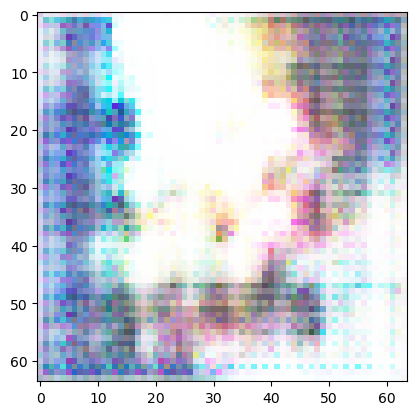

Average Validation Batch Loss (Discriminator): 3.3441666055284442. Average Validation Batch Loss (Generator): 0.08336497977375984.
G LR Scheduler: [0.001]
D LR Scheduler: [0.005] 

Epoch 6==> Duration (sec): 12.8. Average Training Batch Loss (Discriminator): 1.2410867657038298. Average Training Batch Loss (Generator): 1.0458082069862973.
Average Validation Batch Loss (Discriminator): 1.7094128857553006. Average Validation Batch Loss (Generator): 2.5716673970222472.
G LR Scheduler: [0.001]
D LR Scheduler: [0.005] 

Epoch 7==> Duration (sec): 12.8. Average Training Batch Loss (Discriminator): 1.2375403692911973. Average Training Batch Loss (Generator): 1.0576926698180085.
Average Validation Batch Loss (Discriminator): 1.6965251475572587. Average Validation Batch Loss (Generator): 0.3479175554215908.
G LR Scheduler: [0.001]
D LR Scheduler: [0.005] 

Epoch 8==> Duration (sec): 12.9. Average Training Batch Loss (Discriminator): 1.2668293890221551. Average Training Batch Loss (Generator): 0.

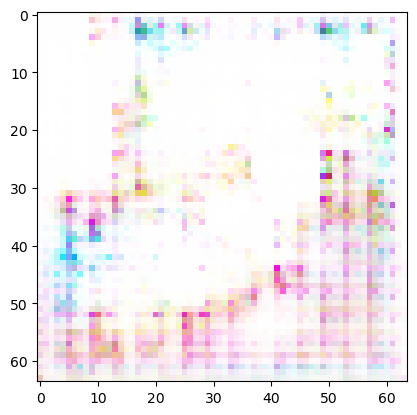

Average Validation Batch Loss (Discriminator): 1.086416116654873. Average Validation Batch Loss (Generator): 0.9019002407789231.
G LR Scheduler: [0.001]
D LR Scheduler: [0.005] 

Epoch 11==> Duration (sec): 12.9. Average Training Batch Loss (Discriminator): 1.291531581160697. Average Training Batch Loss (Generator): 0.9068146345290271.
Average Validation Batch Loss (Discriminator): 1.2374760687351227. Average Validation Batch Loss (Generator): 1.0112534940242768.
G LR Scheduler: [0.001]
D LR Scheduler: [0.005] 

Epoch 12==> Duration (sec): 12.8. Average Training Batch Loss (Discriminator): 1.2759847966649316. Average Training Batch Loss (Generator): 0.9506014547564766.
Average Validation Batch Loss (Discriminator): 1.2148842397332191. Average Validation Batch Loss (Generator): 0.8286846363544464.
G LR Scheduler: [0.001]
D LR Scheduler: [0.0005] 

Epoch 13==> Duration (sec): 12.8. Average Training Batch Loss (Discriminator): 1.2975695487924597. Average Training Batch Loss (Generator): 0

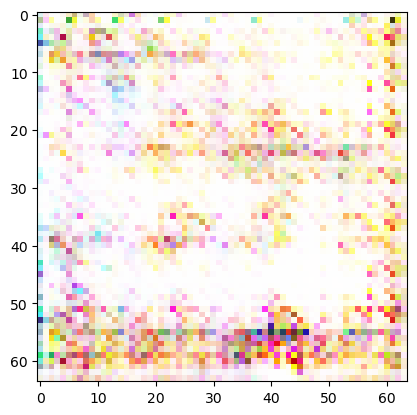

Average Validation Batch Loss (Discriminator): 1.4095174694061279. Average Validation Batch Loss (Generator): 0.6045273911952972.
G LR Scheduler: [0.001]
D LR Scheduler: [0.0005] 

Epoch 16==> Duration (sec): 12.9. Average Training Batch Loss (Discriminator): 1.4002640470591459. Average Training Batch Loss (Generator): 0.6903989724679427.
Average Validation Batch Loss (Discriminator): 1.401470142006874. Average Validation Batch Loss (Generator): 0.6340813308954238.
G LR Scheduler: [0.001]
D LR Scheduler: [0.0005] 

Epoch 17==> Duration (sec): 12.9. Average Training Batch Loss (Discriminator): 1.3961540312116796. Average Training Batch Loss (Generator): 0.6920301319252361.
Average Validation Batch Loss (Discriminator): 1.3571360719203949. Average Validation Batch Loss (Generator): 0.6715933185815811.
G LR Scheduler: [0.001]
D LR Scheduler: [0.0005] 

Epoch 18==> Duration (sec): 12.6. Average Training Batch Loss (Discriminator): 1.3933836087313565. Average Training Batch Loss (Generator)

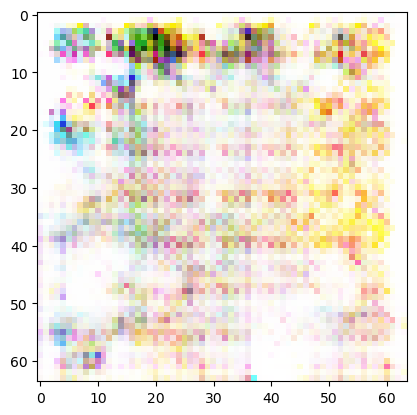

Average Validation Batch Loss (Discriminator): 1.406697359085083. Average Validation Batch Loss (Generator): 0.6376261705160141.
G LR Scheduler: [0.001]
D LR Scheduler: [0.0005] 

Epoch 21==> Duration (sec): 12.3. Average Training Batch Loss (Discriminator): 1.3871195630051874. Average Training Batch Loss (Generator): 0.6961951566826213.
Average Validation Batch Loss (Discriminator): 1.4114758187532426. Average Validation Batch Loss (Generator): 0.6290077090263366.
G LR Scheduler: [0.001]
D LR Scheduler: [0.0005] 

Epoch 22==> Duration (sec): 11.9. Average Training Batch Loss (Discriminator): 1.3903902262991126. Average Training Batch Loss (Generator): 0.693468185229735.
Average Validation Batch Loss (Discriminator): 1.3970280337333678. Average Validation Batch Loss (Generator): 0.6419588828086853.
G LR Scheduler: [0.001]
D LR Scheduler: [0.0005] 

Epoch 23==> Duration (sec): 12.3. Average Training Batch Loss (Discriminator): 1.3898705412582917. Average Training Batch Loss (Generator):

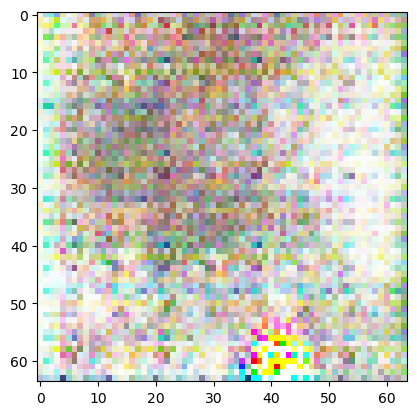

Average Validation Batch Loss (Discriminator): 1.531957632303238. Average Validation Batch Loss (Generator): 0.47598683536052705.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-05] 

Epoch 26==> Duration (sec): 12.4. Average Training Batch Loss (Discriminator): 1.42785484243523. Average Training Batch Loss (Generator): 0.6772141343355179.
Average Validation Batch Loss (Discriminator): 1.5531657034158706. Average Validation Batch Loss (Generator): 0.48097809076309206.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-05] 

Epoch 27==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4081433408368718. Average Training Batch Loss (Generator): 0.6839932618357919.
Average Validation Batch Loss (Discriminator): 1.4994349873065949. Average Validation Batch Loss (Generator): 0.5527385532855987.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-05] 

Epoch 28==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4027530717849732. Average Training Batch Loss (Generator): 0

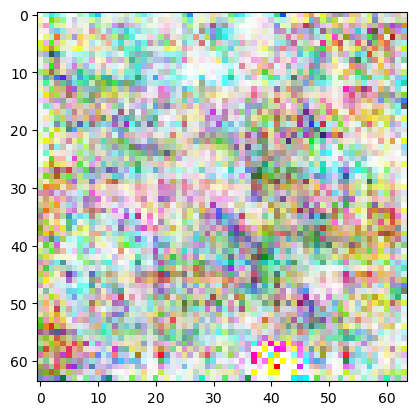

Average Validation Batch Loss (Discriminator): 1.3910532981157302. Average Validation Batch Loss (Generator): 0.5758937549591064.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-05] 

Epoch 31==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.3989906500686298. Average Training Batch Loss (Generator): 0.6874836362491954.
Average Validation Batch Loss (Discriminator): 1.4503638303279878. Average Validation Batch Loss (Generator): 0.5374098336696624.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-05] 

Epoch 32==> Duration (sec): 12.3. Average Training Batch Loss (Discriminator): 1.3960919069701976. Average Training Batch Loss (Generator): 0.6890492646802555.
Average Validation Batch Loss (Discriminator): 1.4085033756494523. Average Validation Batch Loss (Generator): 0.5606187742948532.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-05] 

Epoch 33==> Duration (sec): 12.3. Average Training Batch Loss (Discriminator): 1.3966431061246178. Average Training Batch Loss (Generator): 

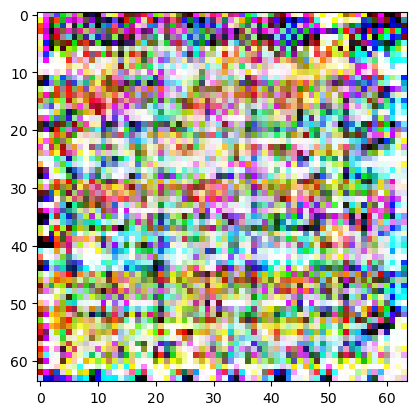

Average Validation Batch Loss (Discriminator): 1.1251175504922868. Average Validation Batch Loss (Generator): 0.9558436959981919.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-06] 

Epoch 36==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.7363473454930565. Average Training Batch Loss (Generator): 0.5232397052103823.
Average Validation Batch Loss (Discriminator): 0.9228022247552872. Average Validation Batch Loss (Generator): 1.4564831793308257.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-06] 

Epoch 37==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.6131661919572136. Average Training Batch Loss (Generator): 0.5945994610678066.
Average Validation Batch Loss (Discriminator): 0.862447222173214. Average Validation Batch Loss (Generator): 1.450753868818283.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-06] 

Epoch 38==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.5052832851084796. Average Training Batch Loss (Generator): 0.

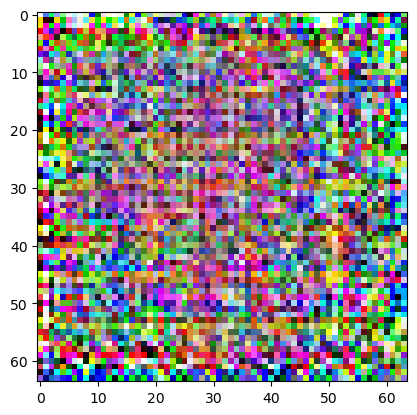

Average Validation Batch Loss (Discriminator): 0.7162064099311829. Average Validation Batch Loss (Generator): 1.3614055716991424.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-06] 

Epoch 41==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.3533995132554661. Average Training Batch Loss (Generator): 0.7037265018983321.
Average Validation Batch Loss (Discriminator): 0.7977724787592888. Average Validation Batch Loss (Generator): 1.1558831083774566.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-06] 

Epoch 42==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.3260351250388405. Average Training Batch Loss (Generator): 0.7301676581122658.
Average Validation Batch Loss (Discriminator): 0.7280714833736419. Average Validation Batch Loss (Generator): 1.221177577972412.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-06] 

Epoch 43==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.2329813410477204. Average Training Batch Loss (Generator): 0

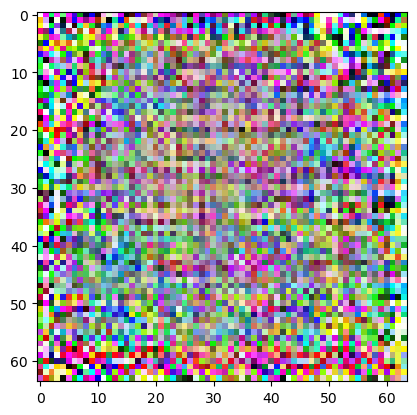

Average Validation Batch Loss (Discriminator): 0.6720066636800766. Average Validation Batch Loss (Generator): 1.3077821028232575.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-06] 

Epoch 46==> Duration (sec): 12.5. Average Training Batch Loss (Discriminator): 1.2415632911161942. Average Training Batch Loss (Generator): 0.7810595208948309.
Average Validation Batch Loss (Discriminator): 0.5353233924508095. Average Validation Batch Loss (Generator): 1.686055042743683.
G LR Scheduler: [0.001]
D LR Scheduler: [5e-06] 

Epoch 47==> Duration (sec): 12.4. Average Training Batch Loss (Discriminator): 1.4090862043337389. Average Training Batch Loss (Generator): 0.6565994358062744.
Average Validation Batch Loss (Discriminator): 1.2409087187051773. Average Validation Batch Loss (Generator): 0.581766163110733.
G LR Scheduler: [0.0001]
D LR Scheduler: [5e-06] 

Epoch 48==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4012270026857203. Average Training Batch Loss (Generator): 0

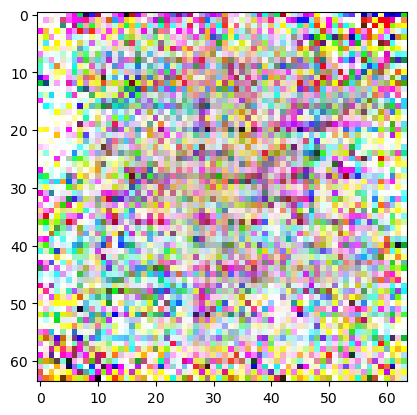

Average Validation Batch Loss (Discriminator): 1.2688628861308098. Average Validation Batch Loss (Generator): 0.553068888783455.
G LR Scheduler: [0.0001]
D LR Scheduler: [5e-06] 

Epoch 51==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.3769869804382324. Average Training Batch Loss (Generator): 0.7040766602754593.
Average Validation Batch Loss (Discriminator): 1.3086698105931283. Average Validation Batch Loss (Generator): 0.5214617437124253.
G LR Scheduler: [0.0001]
D LR Scheduler: [5e-06] 

Epoch 52==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.3715837976065548. Average Training Batch Loss (Generator): 0.703889932253144.
Average Validation Batch Loss (Discriminator): 1.2536212319135667. Average Validation Batch Loss (Generator): 0.5590217453241348.
G LR Scheduler: [0.0001]
D LR Scheduler: [5e-06] 

Epoch 53==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4123689316077666. Average Training Batch Loss (Generator):

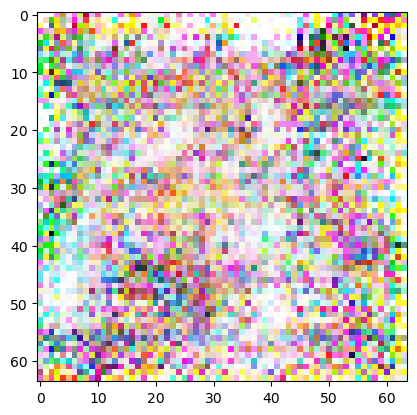

Average Validation Batch Loss (Discriminator): 1.111493403017521. Average Validation Batch Loss (Generator): 0.6997782599925995.
G LR Scheduler: [0.0001]
D LR Scheduler: [5.000000000000001e-07] 

Epoch 56==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4491889431259848. Average Training Batch Loss (Generator): 0.667078324989839.
Average Validation Batch Loss (Discriminator): 1.0772084498405456. Average Validation Batch Loss (Generator): 0.7364176589250565.
G LR Scheduler: [0.0001]
D LR Scheduler: [5.000000000000001e-07] 

Epoch 57==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4549997849356044. Average Training Batch Loss (Generator): 0.6634142745083028.
Average Validation Batch Loss (Discriminator): 1.0193220600485802. Average Validation Batch Loss (Generator): 0.8067061483860016.
G LR Scheduler: [0.0001]
D LR Scheduler: [5.000000000000001e-07] 

Epoch 58==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4564730888

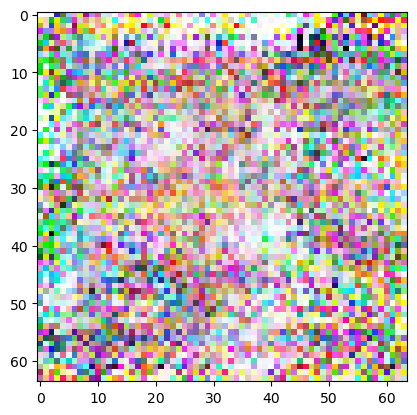

Average Validation Batch Loss (Discriminator): 0.9376571464538574. Average Validation Batch Loss (Generator): 0.924249307513237.
G LR Scheduler: [1e-05]
D LR Scheduler: [5.000000000000001e-07] 

Epoch 61==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4418127453327179. Average Training Batch Loss (Generator): 0.6744423369385979.
Average Validation Batch Loss (Discriminator): 0.9186392417550087. Average Validation Batch Loss (Generator): 0.9535950517654419.
G LR Scheduler: [1e-05]
D LR Scheduler: [5.000000000000001e-07] 

Epoch 62==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4371238453279842. Average Training Batch Loss (Generator): 0.6765639586882157.
Average Validation Batch Loss (Discriminator): 0.897016065120697. Average Validation Batch Loss (Generator): 0.9879866516590119.
G LR Scheduler: [1e-05]
D LR Scheduler: [5.000000000000001e-07] 

Epoch 63==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4341597796028

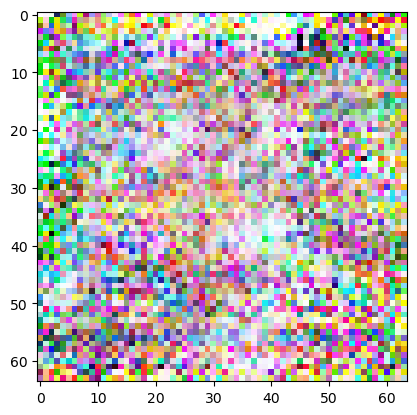

Average Validation Batch Loss (Discriminator): 0.8769315230846405. Average Validation Batch Loss (Generator): 1.0210570335388183.
G LR Scheduler: [1e-05]
D LR Scheduler: [5.000000000000001e-07] 

Epoch 66==> Duration (sec): 12.3. Average Training Batch Loss (Discriminator): 1.4237504171241413. Average Training Batch Loss (Generator): 0.6814623699946837.
Average Validation Batch Loss (Discriminator): 0.8718093594908715. Average Validation Batch Loss (Generator): 1.0300377786159516.
G LR Scheduler: [1e-05]
D LR Scheduler: [5.000000000000001e-08] 

Epoch 67==> Duration (sec): 12.3. Average Training Batch Loss (Discriminator): 1.4228436676480554. Average Training Batch Loss (Generator): 0.6812259742346677.
Average Validation Batch Loss (Discriminator): 0.8637671512365341. Average Validation Batch Loss (Generator): 1.044521369934082.
G LR Scheduler: [1e-05]
D LR Scheduler: [5.000000000000001e-08] 

Epoch 68==> Duration (sec): 12.3. Average Training Batch Loss (Discriminator): 1.424713056683

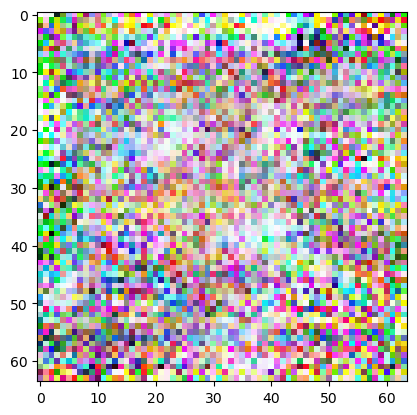

Average Validation Batch Loss (Discriminator): 0.8594077137112618. Average Validation Batch Loss (Generator): 1.0531082594394683.
G LR Scheduler: [1.0000000000000002e-06]
D LR Scheduler: [5.000000000000001e-08] 

Epoch 71==> Duration (sec): 12.2. Average Training Batch Loss (Discriminator): 1.4277961089394309. Average Training Batch Loss (Generator): 0.676545201052319.
Average Validation Batch Loss (Discriminator): 0.859143351316452. Average Validation Batch Loss (Generator): 1.0539510118961335.
G LR Scheduler: [1.0000000000000002e-06]
D LR Scheduler: [5.000000000000001e-08] 

Epoch 72==> Duration (sec): 12.3. Average Training Batch Loss (Discriminator): 1.427569026405161. Average Training Batch Loss (Generator): 0.6767957902496511.
Average Validation Batch Loss (Discriminator): 0.8590374484658241. Average Validation Batch Loss (Generator): 1.054483675956726.
G LR Scheduler: [1.0000000000000002e-06]
D LR Scheduler: [5.000000000000001e-08] 

Epoch 73==> Duration (sec): 12.3. Average Tra

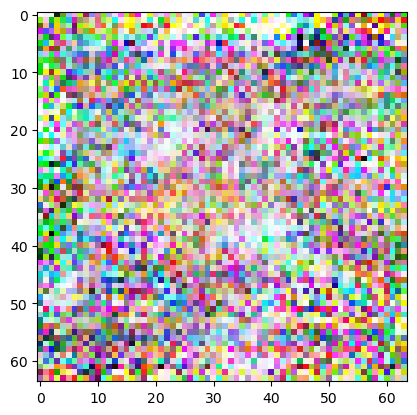

Average Validation Batch Loss (Discriminator): 0.8581698790192605. Average Validation Batch Loss (Generator): 1.056918112039566.
G LR Scheduler: [1.0000000000000002e-06]
D LR Scheduler: [5.000000000000001e-08] 

Epoch 76==> Duration (sec): 12.5. Average Training Batch Loss (Discriminator): 1.4267536306923085. Average Training Batch Loss (Generator): 0.6775148152763193.
Average Validation Batch Loss (Discriminator): 0.8579671728610992. Average Validation Batch Loss (Generator): 1.0575728380680085.
G LR Scheduler: [1.0000000000000002e-06]
D LR Scheduler: [5.000000000000001e-08] 

Epoch 77==> Duration (sec): 12.7. Average Training Batch Loss (Discriminator): 1.426536604328589. Average Training Batch Loss (Generator): 0.6776832983710549.
Average Validation Batch Loss (Discriminator): 0.8576168462634086. Average Validation Batch Loss (Generator): 1.0584754145145416.
G LR Scheduler: [1.0000000000000002e-06]
D LR Scheduler: [5.000000000000002e-09] 

Epoch 78==> Duration (sec): 12.3. Average T

In [7]:
epoch_count = 80
batch_size = 64
discriminator_epoch_loss_list = []
generator_epoch_loss_list = []

discriminator_val_loss_list = []
generator_val_loss_list = []

no_improvement_count = 0
best_loss = np.inf

test_data_loader = DataLoader(val_dataset, batch_size=1)
test_text = [next(iter(test_data_loader))[1].to('cuda') for i in range(2)]
# get noise from normal distribution to be used for test images
test_noise = torch.randn(1, 100, device='cuda')
test_image_results = []


for epoch in range(epoch_count): # train GAN epoch_count number of times
    discriminator_batch_loss_list = []
    generator_batch_loss_list = []
    epoch_start = time.time()
    for idx, (image, text) in enumerate(data_loader, 0): # iterate through the training data loader (get batched data)
        # batch_start = time.time()
        image = image.to('cuda')
        text = text.to('cuda')
        text_4g = torch.unsqueeze(text, 1).long()
        if idx % 3 == 0:
            # set gradient for all discriminator parametrs to None
            discriminator.zero_grad()
            # get discriminator predictions
            predictions_real = discriminator(image, text)
            # vector of ones
            labels_real = torch.ones(predictions_real.size(0)).to('cuda')
            # get discriminator loss on real images
            d_batch_loss_real = loss(predictions_real, labels_real)
            # backwards propogation for discriminator (these gardients will be accumulated with the gradients from the synthetic image results)
            d_batch_loss_real.backward()
            # get noise from normal distribution for this batch round
            noise = torch.randn(batch_size, 100, device='cuda')
            # generate synthetic images
            synthetic = generator(noise, text_4g)
            # get discriminator predictions on synthetic images
            predictions_synthetic = discriminator(synthetic.detach(), text)
            # vector of zeros
            labels_synthetic = torch.zeros(predictions_synthetic.size(0)).to('cuda')
            # get discriminator loss on synthetic images
            d_batch_loss_synthetic = loss(predictions_synthetic, labels_synthetic)
            # backwards propogation for discriminator (these gardients are accumulated with the gradients from the real image results)
            d_batch_loss_synthetic.backward()
            # update discriminator
            discriminator_optimizer.step()
        else:
            # get discriminator predictions
            predictions_real = discriminator(image, text)
            # vector of ones
            labels_real = torch.ones(predictions_real.size(0)).to('cuda')
            # get discriminator loss on real images
            d_batch_loss_real = loss(predictions_real, labels_real)
            # get noise from normal distribution for this batch round
            noise = torch.randn(batch_size, 100, device='cuda')
            # generate synthetic images
            synthetic = generator(noise, text_4g)
            # get discriminator predictions on synthetic images
            predictions_synthetic = discriminator(synthetic.detach(), text)
            # vector of zeros
            labels_synthetic = torch.zeros(predictions_synthetic.size(0)).to('cuda')
            # get discriminator loss on synthetic images
            d_batch_loss_synthetic = loss(predictions_synthetic, labels_synthetic)
        # set gradient for all generator parametrs to None
        generator.zero_grad(set_to_none=True)
        # get discriminator predictions on synthetic images
        predictions_synthetic_updated = discriminator(synthetic, text)
        # generator loss
        generator_batch_loss = loss(predictions_synthetic_updated, labels_real)
        # backwards propogation for generator
        generator_batch_loss.backward()
        # update generator
        generator_optimizer.step()

        # batch_end = time.time()
        # append discriminator batch loss
        discriminator_batch_loss_list.append(d_batch_loss_synthetic.item() + d_batch_loss_real.item()) 
        # append generator batch loss
        generator_batch_loss_list.append(generator_batch_loss.item())

        # print update every 300 batches
        # if idx % 300 == 0:
        #     print(f"Batch # {idx}==> Batch Loss (Discriminator): {discriminator_batch_loss_list[idx]}. Batch Loss (Generator): {generator_batch_loss}.") # Cumulative Average Batch Loss (Generator): {np.mean(generator_batch_loss_list)}
    epoch_end = time.time()
    print(f"Epoch {epoch}==> Duration (sec): {round((epoch_end - epoch_start),1)}. Average Training Batch Loss (Discriminator): {np.mean(discriminator_batch_loss_list)}. Average Training Batch Loss (Generator): {np.mean(generator_batch_loss_list)}.")
    generator_epoch_loss_list.append(np.mean(generator_batch_loss_list))
    discriminator_epoch_loss_list.append(np.mean(discriminator_batch_loss_list))
    
    discriminator_val_batch_loss_list = []
    generator_val_batch_loss_list = []

    with torch.no_grad():
        for idx, (image, text) in enumerate(val_data_loader, 0): # iterate through the training data loader (get batched data)
            # batch_start = time.time()
            val_image = image.to('cuda')
            val_text = text.to('cuda')
            # format text to be used as input to the generator
            val_text_4g = torch.unsqueeze(val_text, 1).long()
            # get discriminator predictions
            val_predictions_real = discriminator(val_image, val_text)
            # vector of ones
            val_labels_real = torch.ones(val_predictions_real.size(0)).to('cuda')
            # get discriminator loss on real images
            val_d_batch_loss_real = loss(val_predictions_real, val_labels_real)
            # get noise from normal distribution for this batch round
            val_noise = torch.randn(batch_size, 100, device='cuda')
            # generate synthetic images
            val_synthetic = generator(val_noise, val_text_4g)
            # get discriminator predictions on synthetic images
            val_predictions_synthetic = discriminator(val_synthetic.detach(), val_text)
            # vector of zeros
            val_labels_synthetic = torch.zeros(val_predictions_synthetic.size(0)).to('cuda')
            # get discriminator loss on synthetic images
            val_d_batch_loss_synthetic = loss(val_predictions_synthetic, val_labels_synthetic)
            # generator loss
            val_generator_batch_loss = loss(val_predictions_synthetic, val_labels_real)
            # batch_end = time.time()
            # append discriminator batch loss
            discriminator_val_batch_loss_list.append(val_d_batch_loss_synthetic.item() + val_d_batch_loss_real.item()) 
            # append generator batch loss
            generator_val_batch_loss_list.append(val_generator_batch_loss.item())
        # check (visualize) generator result every 5 epoch and lr status for generator and discriminator
        if epoch % 5 == 0:
            print(f"G LR Scheduler: {generator_lr_scheduler.get_last_lr()}")
            print(f"D LR Scheduler: {discriminator_lr_scheduler.get_last_lr()} \n")
            test_synthetic = generator(test_noise, test_text[0], batch_size=1).detach().to('cpu')
            current_image_result = torchvision.utils.make_grid(tensor=test_synthetic, normalize=True)
            test_image_results.append(current_image_result)
            visualization_helper(current_image_result)
            plt.show()
    print(f"Average Validation Batch Loss (Discriminator): {np.mean(discriminator_val_batch_loss_list)}. Average Validation Batch Loss (Generator): {np.mean(generator_val_batch_loss_list)}.")
    generator_val_loss_list.append(np.mean(generator_val_batch_loss_list))
    discriminator_val_loss_list.append(np.mean(discriminator_val_batch_loss_list))

    generator_lr_scheduler.step(generator_epoch_loss_list[epoch])
    discriminator_lr_scheduler.step(discriminator_epoch_loss_list[epoch])
    # print(f"G LR Scheduler: {generator_lr_scheduler.get_last_lr()}")
    # print(f"D LR Scheduler: {discriminator_lr_scheduler.get_last_lr()} \n")
    

    # early stop condition. elected to ignore the first 3 epoch to let model "warm-up".
    if epoch >= 3:
        if generator_epoch_loss_list[epoch] < best_loss:
            no_improvement_count = 0
            best_loss = generator_val_loss_list[epoch]
        elif discriminator_epoch_loss_list[epoch] >= (np.mean(discriminator_epoch_loss_list[epoch-2:epoch])*75):
            no_improvement_count+=1

        if no_improvement_count > 12:
            print("Early Stopping! Not Enough Generator Improvement!")
            break


In [15]:
del generator
del discriminator
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Test
# torch.manual_seed(12)
# test_data_loader = DataLoader(val_dataset, batch_size=1)
# # get noise from normal distribution to be used for all test images
# test_noise = torch.randn(1, 100, device='cuda')
# test_image_results = []# {}
# # get test data
# with torch.no_grad():
#     # fig = plt.figure()
#     for i in range(4):
#         text = next(iter(test_data_loader))[1].to('cuda')
#         # text = torch.unsqueeze(text, 1).long()
#         synthetic = generator(test_noise, text, batch_size=1).detach().to('cpu')
#         # test_image_results[text].append(torchvision.utils.make_grid(tensor=synthetic, normalize=True))
#         test_image_results.append(torchvision.utils.make_grid(tensor=synthetic, normalize=True))
#         visualization_helper(test_image_results[i])
#         plt.show()
#         # plt.imshow(np.transpose(test_image_results[i]))